In [1]:
import pandas as pd
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections

In [2]:
res_df = pd.read_pickle('full_testing_results_AGNet_best.pkl')

y_true, y_pred = res_df.y_true, res_df.y_pred

from sklearn.metrics import r2_score, mean_absolute_error
scores = r2_score(y_true, y_pred, multioutput='raw_values')
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')

spatial_params = [
        'Stride Length(cm)/L', 'Stride Length(cm)/R',
        'HH Base Support(cm)/L', 'HH Base Support(cm)/R',
    ]
temporal_params = [
        'Cycle Time(sec)/L', 'Cycle Time(sec)/R',
        'Stance Time(sec)/L', 'Stance Time(sec)/R',
        'Double Supp. Time(sec)/L', 'Double Supp. Time(sec)/R',
        'Swing Time(sec)/L', 'Swing Time(sec)/R',
    ]
etc_params = [
        'Functional Amb. Profile',
        'Velocity',
        'Cadence',
    ]

target_columns = spatial_params + temporal_params + etc_params

spatial_ixs = np.array([target_columns.index(name) for name in spatial_params])
temporal_ixs = np.array([target_columns.index(name) for name in temporal_params])
etc_ixs = np.array([target_columns.index(name) for name in etc_params])


print('R^2 : ', 'temp : ', scores[temporal_ixs].mean(), 
                'spatial : ', scores[spatial_ixs].mean(),
                'etc : ', scores[etc_ixs].mean())
print('MAE : ', 'temp : ', mae[temporal_ixs].mean(), 
                'spatial : ', mae[spatial_ixs].mean(),
                'etc : ', mae[etc_ixs].mean())


R^2 :  temp :  0.7952222409782288 spatial :  0.8287942398717382 etc :  0.9063482816525242
MAE :  temp :  0.037713967 spatial :  2.7422988 etc :  3.817827


In [3]:
def scatterplots(target_columns, y_true, y_pred):
    pred_and_gt = {k: [] for k in target_columns}

    for i, col in enumerate(target_columns):
        pred_and_gt[col].append([y_pred[:, i], y_true[:, i]])

    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i, col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p, g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

    axes = axes.flatten()

    # for i, col in enumerate(target_columns):
    #     part_of_df = df.loc[df.name == col]
    #     ax = axes[i]
    #     part_of_df.plot.scatter(
    #         x="gt", y="pred", c='green', ax=ax, label='data')
    #     ax.set_title(f'name={col}')

    for i, (preds, gts) in enumerate(zip(pp, gg)):
        ax = axes[i]
        preds = np.array(preds)
        gts = np.array(gts)
        lower_ixs = np.where(min(gts) <= preds)[0]
        upper_ixs = np.where(preds <= max(gts))[0]

        valid_ixs = np.array(list(set(lower_ixs).intersection(set(upper_ixs))))

        preds = preds[valid_ixs]
        gts = gts[valid_ixs]
        ax.scatter(preds, gts, c='g', label='data')
        ax.plot([min(gts), max(gts)], [min(gts), max(gts)],
                'r--', label='GT=PRED')
        ax.set_title(f'name={target_columns[i]}')
        ax.legend()

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

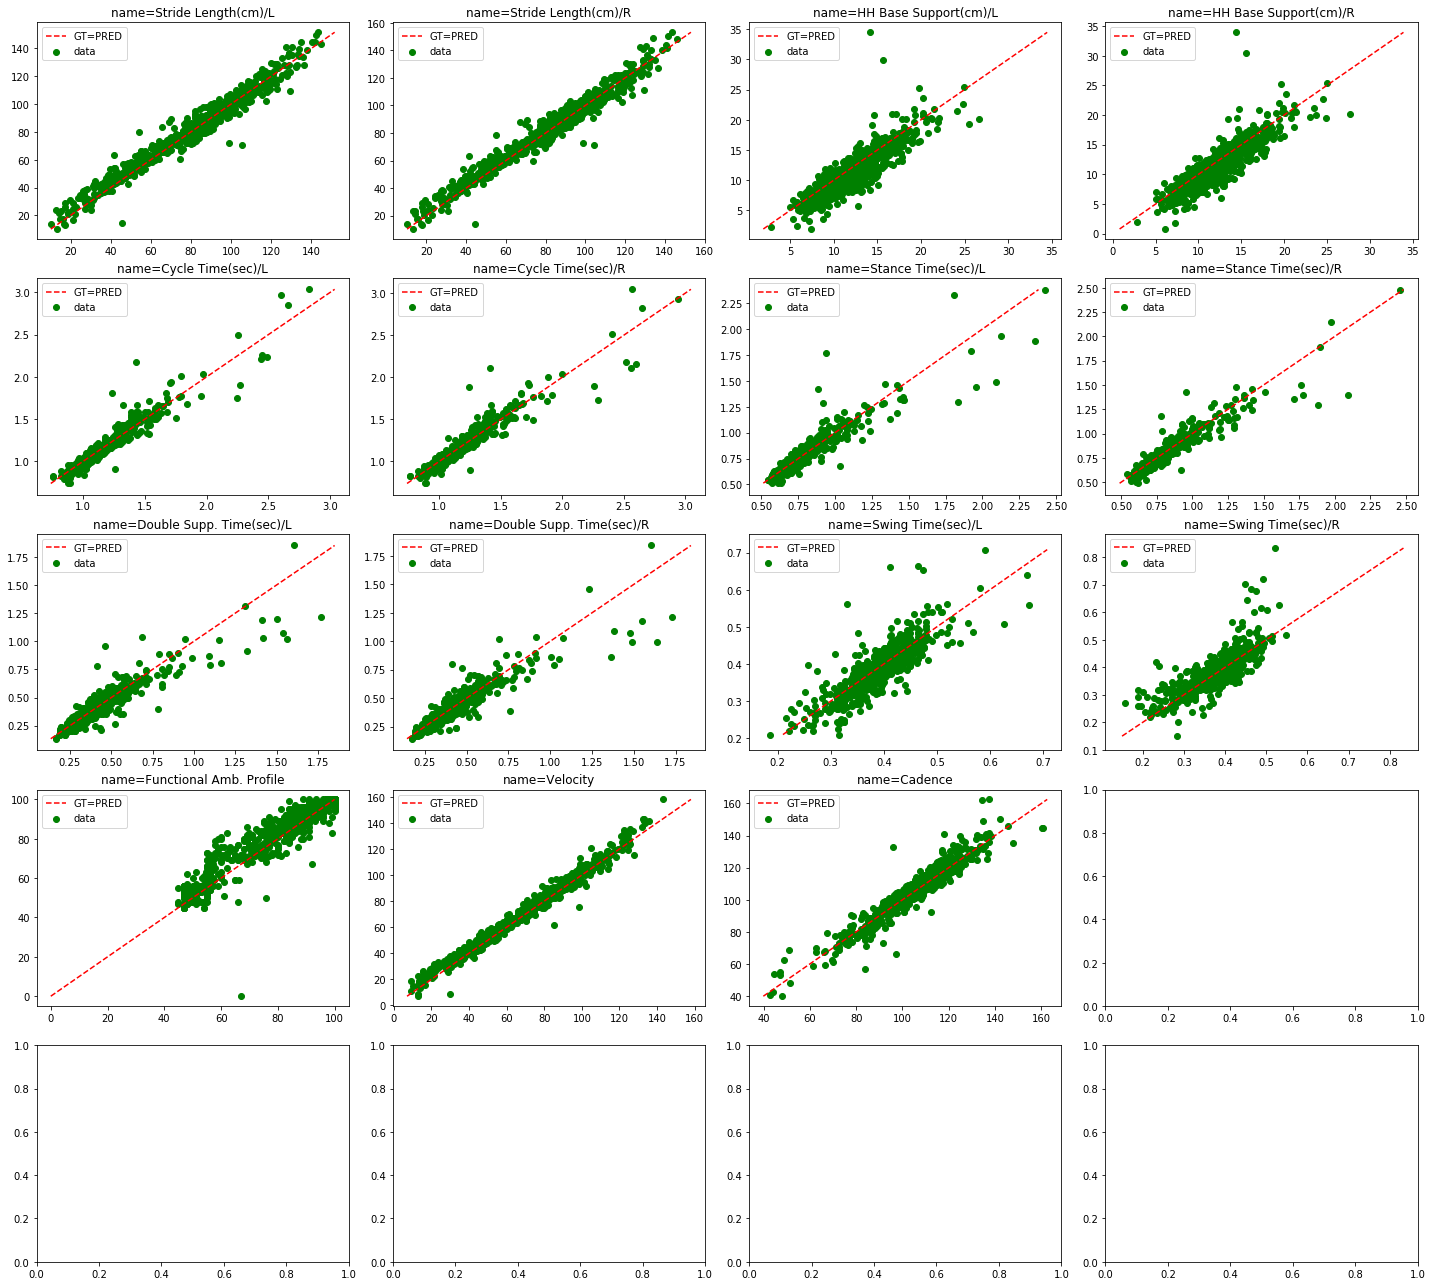

In [4]:
scatterplots(target_columns, y_true.values, y_pred.values)

In [5]:
def get_prediction_intervals(y_true, y_pred, cname):
    sum_errs = ((y_true[cname] - y_pred[cname])**2).sum()
    stdev = np.sqrt(1/(len(y_true[cname])-2) * sum_errs)
    # calculate prediction interval
    interval = 1.96 * stdev
    
    return interval

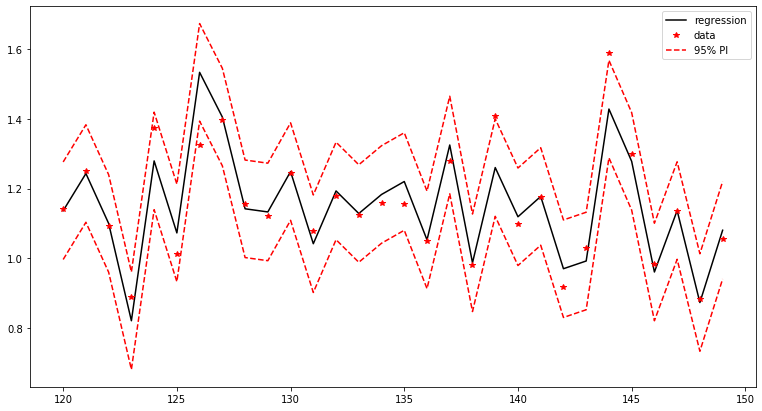

In [33]:
cname = 'Cycle Time(sec)/L'

PI = get_prediction_intervals(y_true, y_pred, cname)

y = y_true[cname][120:150]
yhat = y_pred[cname][120:150]

lower_bound, upper_bound = yhat-PI, yhat+PI

fig, ax = plt.subplots(figsize=(13,7))

ax.plot(yhat, 'k-', label='regression')
ax.plot(y, 'r*', label='data')
ax.plot(lower_bound, 'r--', label='95% PI')
ax.plot(upper_bound, 'r--')

ax.legend()

In [8]:
data = {'pname': [], 'values': [], 'source': []}

for df,source in zip([res_df.y_true, res_df.y_pred], ['GaitRite', 'Vision']):
    val_arr = df.values.flatten()
    data['pname'] += list(df.columns)*len(df)
    data['values'] += val_arr.tolist()
    data['source'] += [source]*val_arr.size
    
test_result_data = pd.DataFrame(data)

In [9]:
def draw_boxplots(test_result_data, columns, figsize=(15,7)):
    fig, ax = plt.subplots(figsize=(15,7))
    sns.boxplot(x="pname",
                y="values", 
                hue="source",
                data=test_result_data[test_result_data.pname.isin(columns)], ax=ax, sym='')

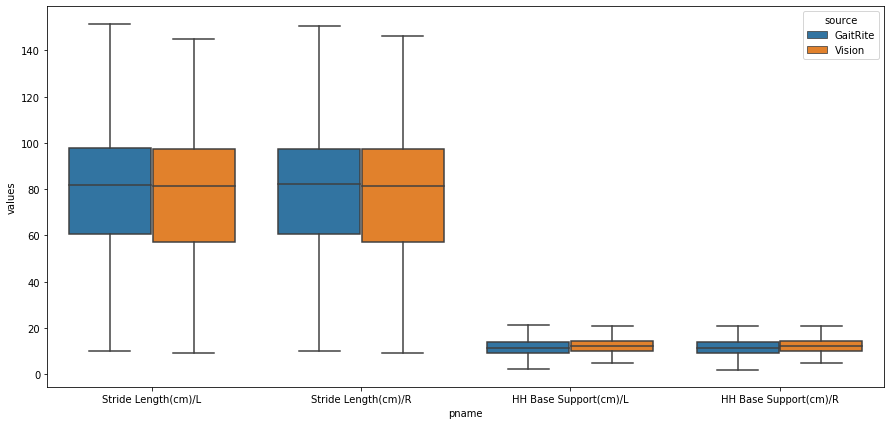

In [13]:
draw_boxplots(test_result_data, columns=spatial_params)

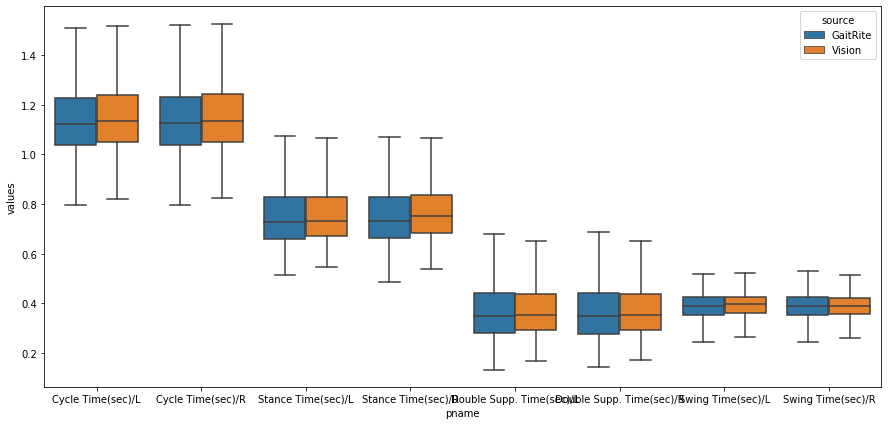

In [14]:
draw_boxplots(test_result_data, columns=temporal_params)

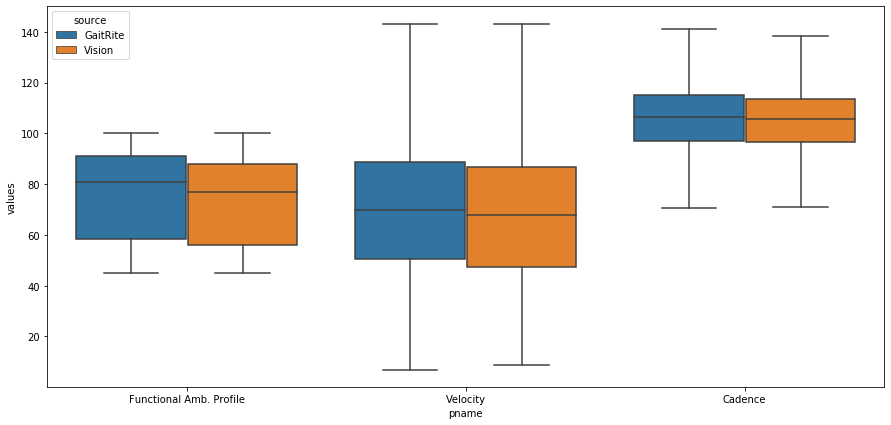

In [15]:
draw_boxplots(test_result_data, columns=etc_params)